In [1]:
import sys
sys.path.insert(1, '../src/magpies/')
from magpies import *
from atmos import *
import numpy as np
from math import *
from scipy.optimize import minimize
import matplotlib as mpl
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
## Radius and mass of neutron star
Rns = 12  ## km
Mns = 1.4 ## M_solar
Tb = pow(10, 7.1730)  ## K
Bp = 1e14 ## G

g14c = g14 (Rns, Mns) ## computing the free fall acceleration
 
print ('g14 = ', g14c)

g14 =  1.6054273795798544


In [3]:
## Initialising the atmosphere
atm_iron_2003 = NS_atmosphere ('Potekhin_2003_iron', g14c, Tb, Bp)
atm_iron_2003.describe ()

Surface temperatures for magnetised envelope of NS
Following fit from Potekhin, Yakovlev, Chabrier & Gnedin (2003) for iron envelope
The Astrophysical Journal, Volume 594, Issue 1, pp. 404-418  2003ApJ...594..404P
Same fits are provided in Beznogov, Potekhin & Yakovlev (2021) for iron envelope
Physics Reports, Volume 919, p. 1-68 2021PhR...919....1B


In [4]:
theta = np.linspace (0, pi, 100)  ## theta coordinates
phi   = np.linspace (0, 2*pi, 99) ## phi coordinates

theta1, phi1 = np.meshgrid (theta, phi)

Ts = atm_iron_2003.Ts (theta1) ## Surface temperatures

In [5]:
## Single temperature test
#for i in range (0, Ts.shape[0]):
#    for j in range (0, Ts.shape[1]):
#        Ts[i,j] = 1e6

In [6]:
eph = np.linspace (0.25, 2.99, 275) ## Nicer soft X-ray range
nphot = 1e6

In [7]:
## Here we produce and store the soft X-ray spectra for two orientations: pole on and equatorial 
sp_red_n, map_of_visible = get_redshifted_spectra_pole_obs (theta, phi, Ts, Rns, Mns, eph, nphot)
sp_red_n_eq, map_of_visible = get_redshifted_spectra_equator_obs (theta, phi, Ts, Rns, Mns, eph, nphot)

../src/magpies/magpies.py:148: RuntimeWarning: divide by zero encountered in log
  x = (1.0 - u)*y*(1.0 + u*u*y*y/112.0 - e/100.0*u*y*(np.log(1-y/2.0) + y/2))
../src/magpies/magpies.py:150: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(res)


In [8]:
Teff = compute_Teff (theta, phi, Rns, Ts)
bb1 = single_BB_obs (1.21*Teff, Rns, Mns, eph, nphot)
bb2 = two_BB_obs ([0.4613, 0.2819, 1.0225, 1.1914], Teff, Rns, Mns, eph, nphot)

In [9]:
print (Teff, log10(Teff))

372579.48518829443 5.571218938282175


999971


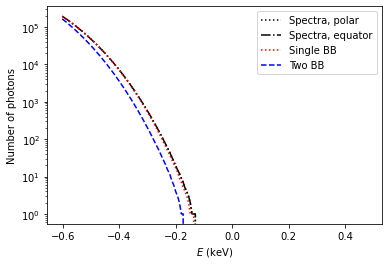

In [10]:
plt.plot (np.log10(eph), sp_red_n, 'k:', label='Spectra, polar')
plt.plot (np.log10(eph), sp_red_n, 'k-.', label='Spectra, equator')
plt.plot (np.log10(eph), bb1, 'r:', label='Single BB')
plt.plot (np.log10(eph), bb2, 'b--', label='Two BB')
plt.xlabel(r'$E$ (keV)')
plt.ylabel('Number of photons')
plt.yscale('log')
plt.legend()


print (np.sum(sp_red_n))

In [22]:
diff = two_BB_diff_obs ([0.4613, 0.2819, 1.0225, 1.1914], Teff, Rns, Mns, sp_red_n, eph, nphot)

In [23]:
print (diff)

76241.38268198614


In [13]:
x0 = [0.2, 0.6, 0.9, 1.2]
res = minimize (two_BB_diff_obs, x0, method = 'Nelder-Mead',args=(Teff, Rns, Mns, sp_red_n, eph, nphot))

In [14]:
print (res)
diff_par = [0,-0.03,0,0]
bb2_opt = two_BB_obs (res.x+diff_par, Teff, Rns, Mns, eph, nphot)
diff = two_BB_diff_obs (res.x + diff_par, Teff, Rns, Mns, sp_red_n, eph, nphot)
print (diff)

 final_simplex: (array([[0.14406619, 0.8559541 , 1.00633825, 1.24609094],
       [0.14405914, 0.85596331, 1.00633753, 1.24609158],
       [0.14406719, 0.85595371, 1.00633807, 1.24609083],
       [0.14406084, 0.85596031, 1.00633634, 1.24609085],
       [0.14406417, 0.8559573 , 1.00634067, 1.24609108]]), array([0.9125731 , 0.91260953, 0.91261178, 0.91262215, 0.91265481]))
           fun: 0.9125730960681719
       message: 'Optimization terminated successfully.'
          nfev: 228
           nit: 123
        status: 0
       success: True
             x: array([0.14406619, 0.8559541 , 1.00633825, 1.24609094])
900.7921063551366


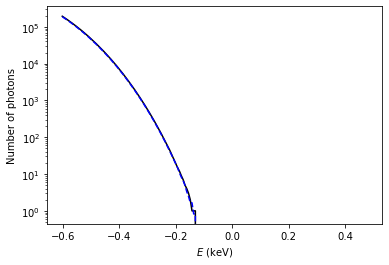

In [15]:
plt.plot (np.log10(eph), sp_red_n, 'k-', label='Spectra, polar')

plt.plot (np.log10(eph), bb2_opt, 'b--', label='Two BB')
plt.xlabel(r'$E$ (keV)')
plt.ylabel('Number of photons')
plt.yscale('log')

In [16]:
x0 = [0.2, 0.6]
res = minimize (BB_diff_obs, x0, method = 'Nelder-Mead',args=(Teff, Rns, Mns, sp_red_n, eph, nphot))



In [17]:
print (res)

 final_simplex: (array([[1.21255626, 0.99990682],
       [1.21255612, 0.99990733],
       [1.21255628, 0.99990687]]), array([61.08205741, 61.08205741, 61.08205741]))
           fun: 61.08205740755353
       message: 'Optimization terminated successfully.'
          nfev: 134
           nit: 64
        status: 0
       success: True
             x: array([1.21255626, 0.99990682])
